# 3. GAN (mnist)

In [1]:
from keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)
import tensorflow as tf
tf.__version__

W0000 00:00:1759925095.960039    9976 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759925095.960056    9976 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759925095.960057    9976 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759925095.960058    9976 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
2025-10-08 15:04:55.962735: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other o

'2.19.0'

In [ ]:
IMAGE_SIZE = 28  # mnist size
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 2  # latent space
EPOCHS = 5
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

In [3]:
# utils.py
import matplotlib.pyplot as plt


def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()


In [4]:
# mnist dataset
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

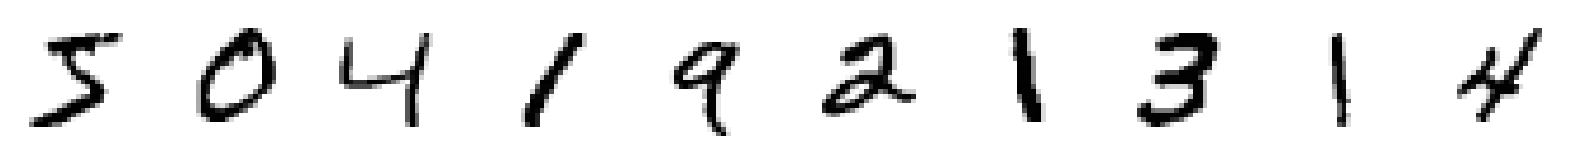

In [5]:
display(x_train)

In [6]:
# GAN discriminator
discriminator_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
)
x = layers.Conv2D(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
# x = layers.BatchNormalization(momentum=0.9)(x)
# x = layers.LeakyReLU(0.2)(x)
# x = layers.Dropout(0.3)(x)
# x = layers.Conv2D(
#     512, kernel_size=4, strides=2, padding="same", use_bias=False
# )(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1, kernel_size=4, strides=2, padding="valid", use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

I0000 00:00:1759925097.952944    9976 gpu_device.cc:2395] Ignoring visible gpu device (device: 1, name: AMD Radeon Graphics, pci bus id: 0000:11:00.0) with AMDGPU version : gfx1036. The supported AMDGPU versions are gfx900, gfx906, gfx908, gfx90a, gfx942, gfx950, gfx1030, gfx1100, gfx1101, gfx1102, gfx1200, gfx1201.
I0000 00:00:1759925098.026617    9976 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15038 MB memory:  -> device: 0, name: AMD Radeon RX 9070 XT, pci bus id: 0000:03:00.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 256)      │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 1, 1)        │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 662,016 (2.53 MB)

 Trainable params: 661,248 (2.52 MB)

 Non-trainable params: 768 (3.00 KB)

In [7]:
# GAN generator
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
# x = layers.BatchNormalization(momentum=0.9)(x)
# x = layers.LeakyReLU(0.2)(x)
# x = layers.Conv2DTranspose(
#     128, kernel_size=3, strides=2, padding="same", use_bias=False
# )(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
output_unscaled = layers.Conv2DTranspose(
    CHANNELS, kernel_size=7, strides=3, padding="valid", use_bias=False,
    activation="tanh",
)(x)
# generator_output = layers.Resizing(IMAGE_SIZE, IMAGE_SIZE, interpolation="bilinear")(output_unscaled)
generator_output = output_unscaled
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 512)      │        16,384 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │        12,544 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,129,152 (8.12 MB)

 Trainable params: 2,127,616 (8.12 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [8]:
# combined model
import keras
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(
            name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(
            name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = keras.ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, \
             tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(
                real_images, training=True
            )
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = keras.ops.ones_like(real_predictions)
            real_noisy_labels = real_labels + \
                NOISE_PARAM * keras.random.uniform(
                keras.ops.shape(real_predictions)
            )
            fake_labels = keras.ops.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - \
                NOISE_PARAM * keras.random.uniform(
                keras.ops.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, 
                                       real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, 
                                       fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, 
                discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, 
                generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, 
                                            real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, 
                                            fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], 
            [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [9]:
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [10]:
dcgan.compile(
    d_optimizer=optimizers.Adam( #legacy.
        learning_rate=LEARNING_RATE, 
        beta_1=ADAM_BETA_1, 
        beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam( #legacy.
        learning_rate=LEARNING_RATE, 
        beta_1=ADAM_BETA_1, 
        beta_2=ADAM_BETA_2
    ),
)

In [11]:
import os
# Create subdirectories
for path in ["./checkpoint","./logs","./models","./output"]:
    try:
        os.mkdir(path)
        print("Directory '%s' created successfully" % path)
    except OSError as error:
        print("Directory '%s' exists" % path)

Directory './checkpoint' exists
Directory './logs' exists
Directory './models' exists
Directory './output' exists


In [ ]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/3-gan-mnist.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/mnist_img_%04d.png" % (epoch),
        )

Epoch 1/100


I0000 00:00:1759925100.247134   10055 service.cc:152] XLA service 0x7fe59000aaa0 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759925100.247148   10055 service.cc:160]   StreamExecutor device (0): AMD Radeon RX 9070 XT, AMDGPU ISA version: gfx1201
2025-10-08 15:05:00.285574: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


   6/1875 ━━━━━━━━━━━━━━━━━━━━ 46s 25ms/step - d_acc: 0.6645 - d_fake_acc: 0.4966 - d_loss: 0.6759 - d_real_acc: 0.8325 - g_acc: 0.5034 - g_loss: 0.7725

I0000 00:00:1759925107.651107   10055 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_acc: 0.9246 - d_fake_acc: 0.9246 - d_loss: -0.1112 - d_real_acc: 0.9245 - g_acc: 0.0754 - g_loss: 5.9036
Saved to ./output/generated_img_0000.png


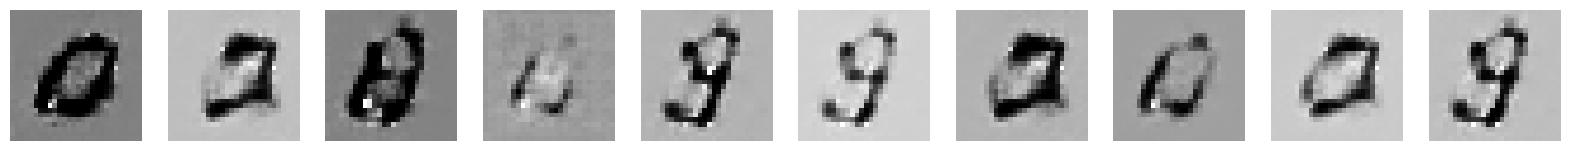

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 55s 24ms/step - d_acc: 0.9711 - d_fake_acc: 0.9739 - d_loss: -0.4411 - d_real_acc: 0.9683 - g_acc: 0.0261 - g_loss: 10.3094
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - d_acc: 0.9981 - d_fake_acc: 0.9984 - d_loss: -0.7707 - d_real_acc: 0.9978 - g_acc: 0.0016 - g_loss: 15.6575
Saved to ./output/generated_img_0001.png


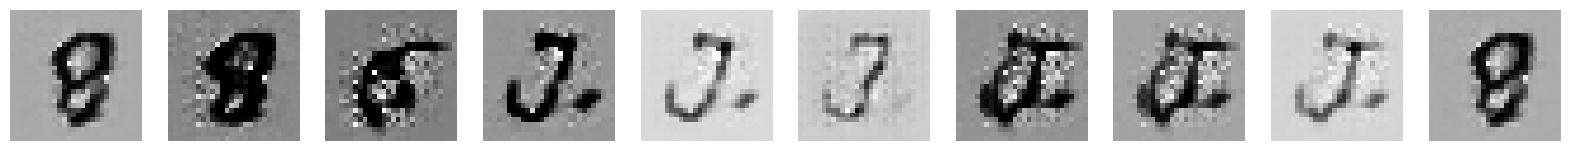

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 48s 26ms/step - d_acc: 0.9989 - d_fake_acc: 0.9990 - d_loss: -0.7816 - d_real_acc: 0.9988 - g_acc: 9.6667e-04 - g_loss: 15.8537
Epoch 3/100
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8020 - d_real_acc: 1.0000 - g_acc: 1.8544e-05 - g_loss: 16.1019
Saved to ./output/generated_img_0002.png


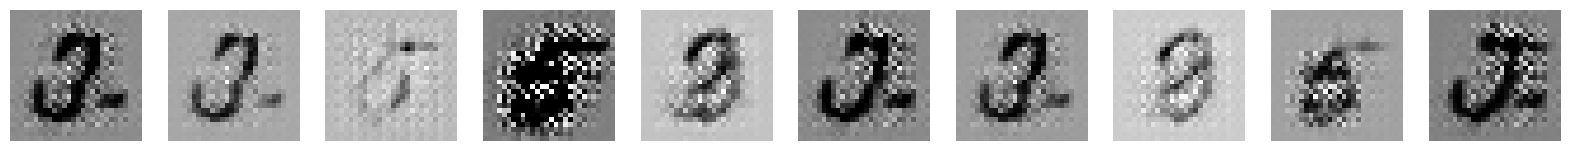

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 47s 25ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8010 - d_real_acc: 1.0000 - g_acc: 3.3333e-05 - g_loss: 16.1066
Epoch 4/100
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8026 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1180
Saved to ./output/generated_img_0003.png


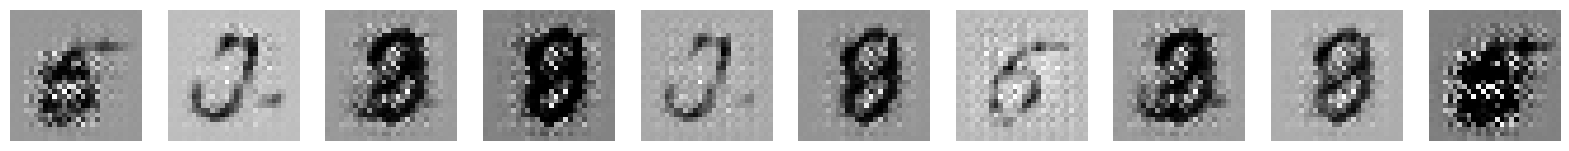

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 46s 25ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8026 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1177
Epoch 5/100
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8026 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1180
Saved to ./output/generated_img_0004.png


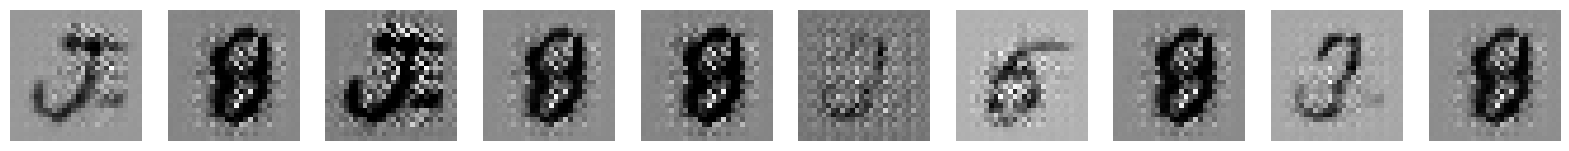

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 46s 25ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8009 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1177
Epoch 6/100
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8006 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1179
Saved to ./output/generated_img_0005.png


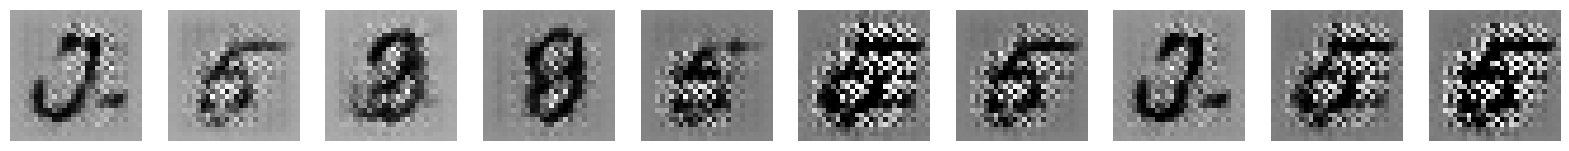

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 46s 25ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8014 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1177
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8009 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1180
Saved to ./output/generated_img_0006.png


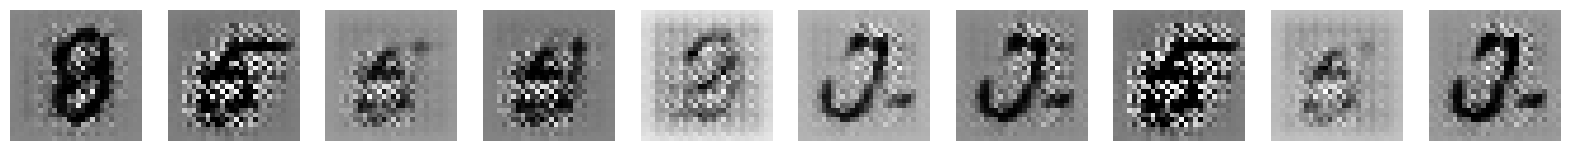

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 46s 25ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8009 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1177
Epoch 8/100
 194/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - d_acc: 1.0000 - d_fake_acc: 1.0000 - d_loss: -0.8041 - d_real_acc: 1.0000 - g_acc: 0.0000e+00 - g_loss: 16.1181

KeyboardInterrupt: 

In [13]:
dcgan_history = dcgan.fit(
    x_train,
    epochs=EPOCHS,
    callbacks=[
#        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [14]:
dcgan_history.history.keys()

NameError: name 'dcgan_history' is not defined

NameError: name 'dcgan_history' is not defined

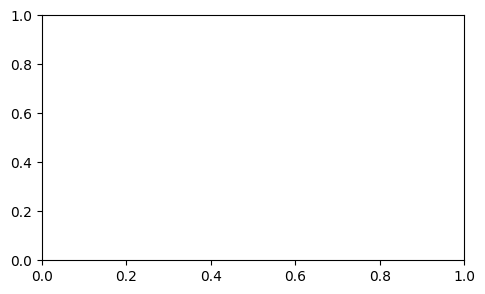

In [15]:
plt.figure(figsize=(12, 7))

for i,param in enumerate(['d_acc', 'd_loss', 'g_acc', 'g_loss']):
    plt.subplot(2, 2, i+1)
    plt.plot(dcgan_history.history[param], label=param)
    plt.legend()
    plt.grid(True)

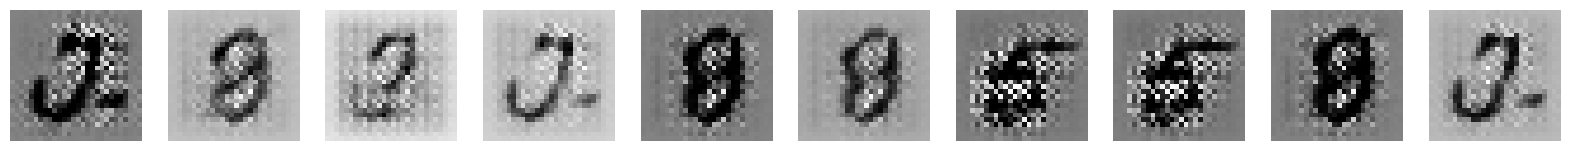

In [22]:
# generate some random latent space points and visualize them

random_latent_vectors = tf.random.normal(shape=(10, 2))
generated_images = dcgan.generator(random_latent_vectors)
generated_images = generated_images * 127.5 + 127.5
generated_images = generated_images.numpy()

generated_images = generated_images.reshape((10, IMAGE_SIZE, IMAGE_SIZE))

display(generated_images)

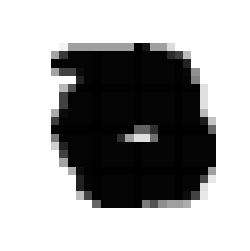

0


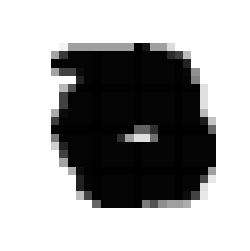

0


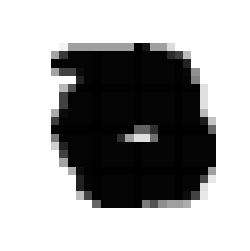

0


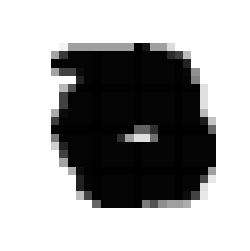

0


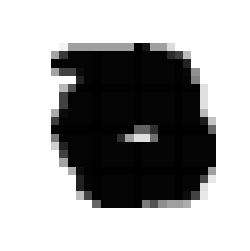

0


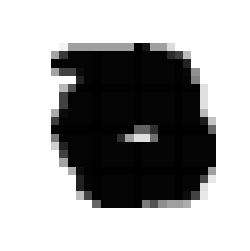

0


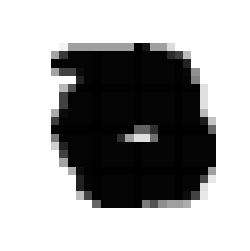

0


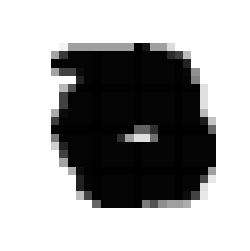

0


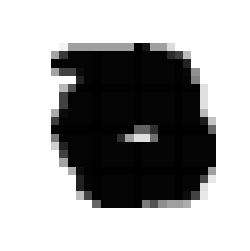

0


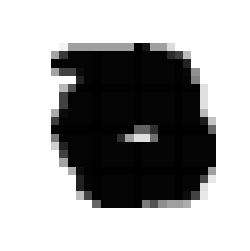

0


In [41]:
# find true images that most closely match the generated ones
import numpy as np

flat_train = x_train.reshape((x_train.shape[0], -1))
for img in generated_images:
    flat_img = img.reshape((1, -1))
    dists = np.linalg.norm(flat_train - flat_img, axis=1)
    idx = int(np.argmin(dists))
    display(np.array([x_train[idx]]), n=1)
    print(y_train[idx])

In [36]:
x_train[0].shape

(28, 28)